In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, Flatten, Lambda, Reshape, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

In [2]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError:
        if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
            print('Running on Google Colab GPU')
        else:
            print('Not connected to a TPU or GPU runtime')

else:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    try:
        if len(physical_devices):
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, enable = True)
                print(f"Using local GPU: {gpu}")
            sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
        else:
            print("No local GPU found")
    except:
        print("Error Mounting a GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using local GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
def filter_df(df, viable_nums=["2", "4", "6"]):
    condition = df['low_res'].str.endswith(tuple(num + ".jpg" for num in viable_nums))
    filtered_df = df[condition]
    return filtered_df

In [4]:
def read_images(df):
    new_df = pd.DataFrame(columns=["low_res", "high_res"])

    for index, row in df.iterrows():
            low_res_path = row["low_res"]
            low_res_img = Image.open(low_res_path)
            low_res_array = np.array(low_res_img)

            high_res_path = row["high_res"]
            high_res_img = Image.open(high_res_path)
            high_res_array = np.array(high_res_img)
            new_row = {
                "low_res" : low_res_array,
                "high_res" : high_res_array,
            }
            new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)
        
    return new_df

In [5]:
EPOCHS = 100
seed = 42

INPUT_SHAPE = (400, 600, 3)
IMAGE_SHAPE = (400, 600)
BATCH_SIZE = 32 

## Data

In [6]:
def load_and_preprocess_image(low_res_path, high_res_path):
    low_res_image = tf.io.read_file(low_res_path)
    low_res_image = tf.image.decode_jpeg(low_res_image, channels=3)
    low_res_image = tf.image.resize(low_res_image, IMAGE_SHAPE)

    high_res_image = tf.io.read_file(high_res_path)
    high_res_image = tf.image.decode_jpeg(high_res_image, channels=3)
    high_res_image = tf.image.resize(high_res_image, IMAGE_SHAPE)
    
    low_res_image = low_res_image / 255.0
    high_res_image = high_res_image / 255.0
    return low_res_image, high_res_image

def create_dataset(data, data_dir, batch_size):
    low_res_paths = data['low_res'].apply(lambda x: os.path.join(data_dir, 'low res', x)).values
    high_res_paths = data['high_res'].apply(lambda x: os.path.join(data_dir, 'high res', x)).values

    dataset = tf.data.Dataset.from_tensor_slices((low_res_paths, high_res_paths))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(batch_size)

    return dataset

# Define constants
BATCH_SIZE = 16
DATA_DIR = 'Data'

# Load CSV file
csv_path = os.path.join(DATA_DIR, 'image_data.csv')
df = pd.read_csv(csv_path)

# Split data into train, validation, and test sets
train_data, val_test_data = train_test_split(df, test_size=0.2, random_state=seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed)

# Create datasets
train_dataset = create_dataset(train_data, DATA_DIR, BATCH_SIZE)
val_dataset = create_dataset(val_data, DATA_DIR, BATCH_SIZE)
test_dataset = create_dataset(test_data, DATA_DIR, BATCH_SIZE)

# Print dataset information
print("Train dataset:", train_dataset)
print("Validation dataset:", val_dataset)
print("Test dataset:", test_dataset)

Train dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None))>
Validation dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None))>
Test dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None))>


In [7]:
len(train_dataset) * BATCH_SIZE

3024

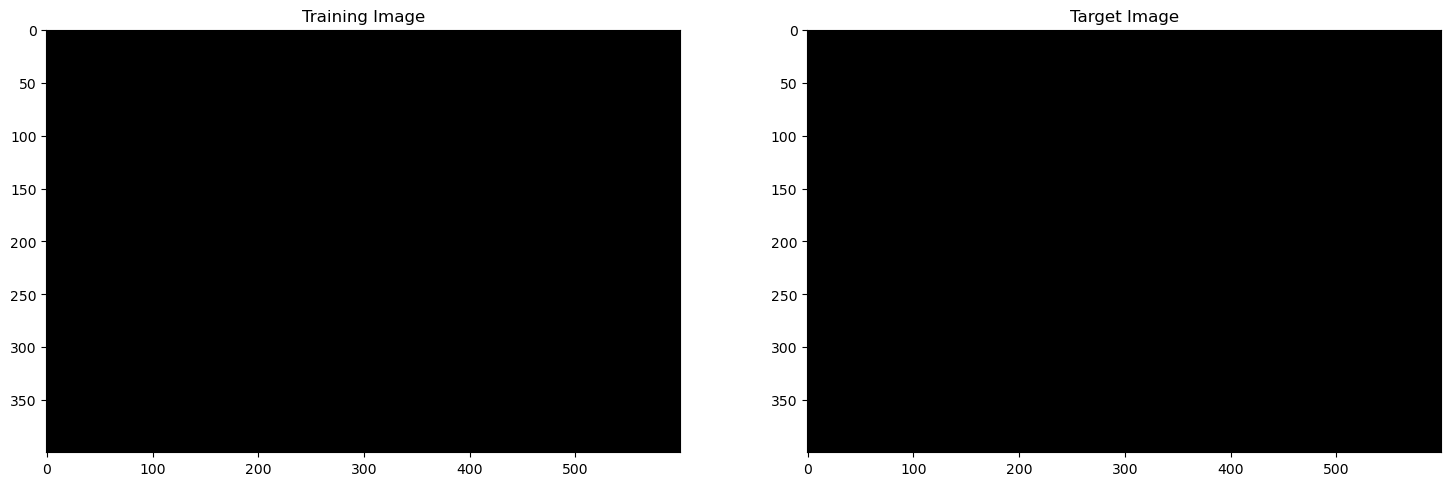

In [8]:
import matplotlib.pyplot as plt

# Create an iterator for the train_dataset
train_iterator = iter(train_dataset)

# Get a batch of training examples
batch_of_images, batch_of_targets = next(train_iterator)

# Visualize the first training example and its target
sample_training_image = batch_of_images[10].numpy()
sample_target_image = batch_of_targets[10].numpy()

# Display the images
plt.figure(figsize=(18, 14))
plt.subplot(1, 2, 1)
plt.imshow(sample_training_image.astype("uint8"))
plt.title("Training Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_target_image.astype("uint8"))
plt.title("Target Image")

plt.show()

In [9]:
def build_conv_model(input_shape=INPUT_SHAPE):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(16, (3, 3), padding='same', activation='elu')(input_img)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv1)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv2)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv3)
    conv5 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv4)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv5)

    conv_model = Model(input_img, output_img)
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    conv_model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

    return conv_model

conv_model = build_conv_model()

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

In [11]:
history = conv_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data = val_dataset,
    callbacks=[early_stopping, reduce_lr_plateau]
)

Epoch 1/100


189/189 [==============================] - 98s 444ms/step - loss: 0.0103 - accuracy: 0.7575 - mae: 0.0646 - rmse: 0.1017 - val_loss: 0.0041 - val_accuracy: 0.8267 - val_mae: 0.0468 - val_rmse: 0.0638 - lr: 0.0010
Epoch 2/100
189/189 [==============================] - 83s 441ms/step - loss: 0.0034 - accuracy: 0.8319 - mae: 0.0423 - rmse: 0.0583 - val_loss: 0.0037 - val_accuracy: 0.8286 - val_mae: 0.0441 - val_rmse: 0.0607 - lr: 0.0010
Epoch 3/100
189/189 [==============================] - 83s 439ms/step - loss: 0.0029 - accuracy: 0.8207 - mae: 0.0369 - rmse: 0.0534 - val_loss: 0.0024 - val_accuracy: 0.8049 - val_mae: 0.0295 - val_rmse: 0.0487 - lr: 0.0010
Epoch 4/100
189/189 [==============================] - 83s 440ms/step - loss: 0.0024 - accuracy: 0.8275 - mae: 0.0314 - rmse: 0.0485 - val_loss: 0.0023 - val_accuracy: 0.8473 - val_mae: 0.0298 - val_rmse: 0.0484 - lr: 0.0010
Epoch 5/100
189/189 [==============================] - 83s 440ms/step - loss: 0.0020 - accuracy: 0.8473 - mae: 0